<a href="https://colab.research.google.com/github/davidsjohnson/blockies-haic/blob/ijcai25/ijcai25/blockies_datasets_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blockies Dataset

This notebook download the blockies dataset and the corresponding trained model.  This is then used to evaluate the model on all datasets.  

Additionally, we provide a review of the various Blocky traits, to review the distributions between ill and healthy Blockies.

In [1]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms as T

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import shap
import torchvision


torch.backends.cudnn.benchmark = True

In [2]:
CLASSES = ['Healthy', 'OCDegen']

modeltype = 'mobilenet'

ds = 'sick_ones_bendbias_v3_2class_normal'
eval_ds = 'sick_ones_bendbias_v3_2class_variation'

random_state = 42

# Setup and Load Datasets

In [3]:
# data downloading and dataset utilities

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)

    return Path(file_path)

In [4]:
def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)
  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label

## Load Dataset and Dataloaders


In [5]:
# download data direcly from sciebo
# (or setup own data location if prefered)

data_dir = download_file(url="https://osf.io/download/kexzt/?view_only=adcc520b88cc4ea3b8236c5178ba3ab5",
                         file_name="blockies_datasets.tar.gz",
                         cache_dir='data', # change this if not using Colab
                         extract=True,
                         force_download=False,
                         archive_folder='blockies_datasets')
data_dir

File already exists at: data/blockies_datasets.tar.gz


/tmp/ipykernel_131263/977350741.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=cache_dir)


File extracted to: data


PosixPath('data/blockies_datasets')

In [6]:
ds_dir = data_dir / ds
eval_ds_dir = data_dir / eval_ds
ds_dir, eval_ds_dir

(PosixPath('data/blockies_datasets/sick_ones_bendbias_v3_2class_normal'),
 PosixPath('data/blockies_datasets/sick_ones_bendbias_v3_2class_variation'))

In [7]:
# 2 class dataset
mean = [0.8068, 0.7830, 0.8005]
std = [0.1093, 0.1136, 0.1029]


transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])


train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')
eval_df = load_dataframe(eval_ds_dir, 'test')

print(len(train_df), len(val_df), len(test_df), len(eval_df))


train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False,
                              num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                             num_workers=6, pin_memory=True)

eval_dataset = ImageDataset(eval_df,  eval_ds_dir / 'test', transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False,
                             num_workers=6, pin_memory=True)   

40000 1000 3000 3000


# Model Loading and Evaluation





In [8]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):
  """Loads a MobileNetV2 model, optionally loading from a checkpoint.

  Args:
    num_classes: The number of output classes.
    pretrained: Whether to load the pre-trained weights.
    checkpoint_path: Path to a checkpoint file to load.

  Returns:
    A MobileNetV2 model.
  """
  model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
  model.classifier[1] = nn.Linear(model.last_channel, num_classes)

  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    if isinstance(checkpoint, dict) and "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"], strict=False)
    else:
            model.load_state_dict(checkpoint, strict=False)
    print(f"Loaded checkpoint from: {checkpoint_path}")

  return model

In [9]:
def set_seed(seed):
  """
  Sets random seeds for reproducibility.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    preds = []
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            preds.extend(predicted.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy, np.array(preds)

In [10]:
checkpoint_path = download_file(url='https://osf.io/download/5crqh/?view_only=adcc520b88cc4ea3b8236c5178ba3ab5',
                                file_name='best_model.pth',
                                cache_dir='checkpoint/mobilenetv2_checkpoint', # change this if not using Colab
                                extract=False,
                                force_download=True)
checkpoint_path

100%|██████████| 8.73M/8.73M [00:04<00:00, 1.98MB/s]

File downloaded to: checkpoint/mobilenetv2_checkpoint/best_model.pth


PosixPath('checkpoint/mobilenetv2_checkpoint/best_model.pth')

In [11]:
# Load the checkpoint
model1 = torch.load("checkpoint/mobilenetv2_checkpoint/best_model.pth", map_location="cpu")

In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Evaluate Model

In [13]:
import torch

checkpoint = torch.load(checkpoint_path, map_location="cpu")

# Check the type and keys
print(type(checkpoint))
if isinstance(checkpoint, dict):
    print("Checkpoint keys:", checkpoint.keys())


<class 'collections.OrderedDict'>
Checkpoint keys: odict_keys(['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var', 'features.0.1.num_batches_tracked', 'features.1.conv.0.0.weight', 'features.1.conv.0.1.weight', 'features.1.conv.0.1.bias', 'features.1.conv.0.1.running_mean', 'features.1.conv.0.1.running_var', 'features.1.conv.0.1.num_batches_tracked', 'features.1.conv.1.weight', 'features.1.conv.2.weight', 'features.1.conv.2.bias', 'features.1.conv.2.running_mean', 'features.1.conv.2.running_var', 'features.1.conv.2.num_batches_tracked', 'features.2.conv.0.0.weight', 'features.2.conv.0.1.weight', 'features.2.conv.0.1.bias', 'features.2.conv.0.1.running_mean', 'features.2.conv.0.1.running_var', 'features.2.conv.0.1.num_batches_tracked', 'features.2.conv.1.0.weight', 'features.2.conv.1.1.weight', 'features.2.conv.1.1.bias', 'features.2.conv.1.1.running_mean', 'features.2.conv.1.1.running_var', 'features.2.conv.1.1.num

In [14]:
# load best model and evaluate
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path)
# Disable in-place operations
for module in model.modules():
    if isinstance(module, torch.nn.ReLU):
        module.inplace = False
    if isinstance(module, torch.nn.Hardtanh):
        module.inplace = False

model.to(device)
'''
_ = evaluate_model(model, train_dataloader, criterion, device)
_ = evaluate_model(model, val_dataloader, criterion, device)
_ = evaluate_model(model, test_dataloader, criterion, device)
_ = evaluate_model(model, eval_dataloader, criterion, device)
'''

Loaded checkpoint from: checkpoint/mobilenetv2_checkpoint/best_model.pth


'\n_ = evaluate_model(model, train_dataloader, criterion, device)\n_ = evaluate_model(model, val_dataloader, criterion, device)\n_ = evaluate_model(model, test_dataloader, criterion, device)\n_ = evaluate_model(model, eval_dataloader, criterion, device)\n'

# Parameter Review

## Preprocess Data Frame

In [15]:
# Get pred for Eval Set

_, _, preds = evaluate_model(model, eval_dataloader, criterion, device)
preds = np.array(preds)
eval_df['pred'] = preds

corr_pred = eval_df['pred'] == eval_df['ill'].astype(int)
print(f'Acc: {corr_pred.astype(int).mean():.4f}')


Evaluation Loss: 0.9196, Evaluation Accuracy: 0.6937
Acc: 0.6937


In [16]:
# add Sphere Diff value for plotting
eval_df['sphere_diff'] = np.abs(eval_df['spherical'] - eval_df['ill_spherical'])

# add label names for better plots
eval_df['ill_label'] = eval_df['ill'].astype(int).map({0: 'Healthy', 1: 'OCDegen'})
eval_df['pred_label'] = eval_df['pred'].astype(int).map({0: 'Healthy', 1: 'OC Degen'})

In [17]:
eval_df.sample(5)

,obj_name,labeling_error,spherical,ill,ill_chars,ill_spherical,num_diff,bending,obj_rotation_roll,obj_rotation_pitch,...,original_id,_attributes_status,label,__module__,__name__,filename,pred,sphere_diff,ill_label,pred_label
572,peaky,False,0.631942,1,"[high_sphere_diff, stretchy, med_bend]",0.038683,1,0.196261,0.302191,-0.543501,...,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,47a781c1-f08f-4374-a41a-106e7d133c4c.png,1,0.593259,OCDegen,OC Degen
1923,peaky,False,0.837571,0,"[high_bend, mutation_color]",0.776235,1,0.258916,-0.507027,-0.739099,...,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,10ac77b8-041e-4a18-9be8-281a45e57e9f.png,1,0.061336,Healthy,OC Degen
451,peaky,False,0.999604,1,"[high_bend, high_sphere_diff, mutation_color]",0.268016,2,0.254026,-0.842149,0.964689,...,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,553fd173-72b5-43bd-b94d-e51aaf8ef1ba.png,1,0.731589,OCDegen,OC Degen
741,peaky,False,0.999979,0,"[mutation_color, stretchy]",1.269089,1,0.011992,-0.274046,0.653089,...,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,708f0d5f-0266-4093-af79-7a566b3bbade.png,1,0.269110,Healthy,OC Degen
2337,peaky,False,0.687884,0,[mutation_color],0.402235,2,0.058610,-0.622732,0.352299,...,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,b98f55c1-2d13-4125-b134-874cd3872b3e.png,1,0.285650,Healthy,OC Degen


In [18]:
eval_df.columns

Index(['obj_name', 'labeling_error', 'spherical', 'ill', 'ill_chars',
       'ill_spherical', 'num_diff', 'bending', 'obj_rotation_roll',
       'obj_rotation_pitch', 'obj_rotation_yaw', 'fliplr', 'position_x',
       'position_y', 'arm_position', 'obj_color', 'obj_color_rgba', 'bg_color',
       'bg_color_rgba', 'resolution', 'id', 'original_id',
       '_attributes_status', 'label', '__module__', '__name__', 'filename',
       'pred', 'sphere_diff', 'ill_label', 'pred_label'],
      dtype='object')

### Generate explanations

In [19]:
from PIL import Image
import shap
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [20]:
_, _, preds = evaluate_model(model, test_dataloader, criterion, device)
preds = np.array(preds)
test_df['pred'] = preds

corr_pred = test_df['pred'] == test_df['ill'].astype(int)
print(f'Acc: {corr_pred.astype(int).mean():.4f}')

Evaluation Loss: 0.2287, Evaluation Accuracy: 0.9043
Acc: 0.9043


In [21]:
def display_images(filenames, true_labels, pred_labels, start=0, num_images=5):
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        idx = start + i
        img = mpimg.imread(filenames[idx])  # Load image
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_labels[idx]}\nPred: {pred_labels[idx]}")
        plt.axis('off')

    plt.show()

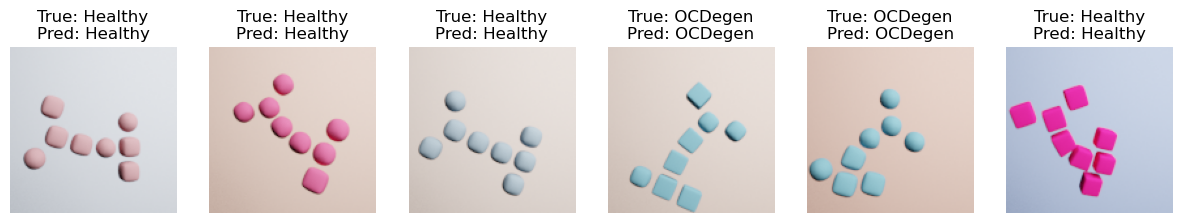

In [22]:
classes = ['Healthy', 'OCDegen']
true_labels = [classes[int(idx)] for idx in test_df['ill'][:10]]
pred_labels = [classes[int(idx)] for idx in test_df['pred'][:10]]
data_dir =  'data/blockies_datasets/sick_ones_bendbias_v3_2class_normal/test/'+test_df['filename']
display_images(data_dir, true_labels, pred_labels, start=1, num_images=6)


## Generating SHAP Explanation

SHAP Explaination for one image, or multiple images Adjust the variable num_samples
1. Pratition explainer

In [41]:
'''Prepare data transformation pipeline'''

mean = [0.8068, 0.7830, 0.8005]
std = [0.1093, 0.1136, 0.1029]

# Function to convert NHWC (SHAP) -> NCHW (PyTorch)
def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2) 
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1) 
    return x

# Function to convert NCHW (PyTorch) -> NHWC (SHAP)
def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)  
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0) 
    return x

transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),  
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
])

inv_transform = torchvision.transforms.Compose([
    # Convert NumPy array to Tensor
    torchvision.transforms.Lambda(lambda x: torch.tensor(x)),  
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
    # Convert back to NumPy
    torchvision.transforms.Lambda(lambda x: x.cpu().numpy()),  
])


def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)  
    with torch.no_grad():
        output = model(img)
    # Return probabilities    
    return torch.nn.functional.softmax(output, dim=1)  


In [42]:
num_samples = [6,7,10] # adjust this to the prefered number of samples to explain

test_images, test_labels = zip(*[test_dataset[i] for i in (num_samples)])
test_images = torch.stack(test_images).to(device)

# Convert images to NumPy format for SHAP
test_images_np = nchw_to_nhwc(test_images).cpu().numpy()  # Convert (N, C, H, W) -> (N, H, W, C)

In [43]:
# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", test_images_np[0].shape)

In [26]:
# Create SHAP Explainer with the model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=CLASSES)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    test_images_np,
    max_evals=1000,  # Number of model evaluations
    batch_size=1,   
    outputs=shap.Explanation.argsort.flip[:2],  # Top-2 predictions
)

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:17,  8.96s/it]               


In [27]:
# Apply inverse transformation to SHAP data
shap_values.data = inv_transform(shap_values.data)

shap_values.values = [val for val in np.moveaxis(shap_values.values, -1, 0)]

In [28]:
# Groundtruth
true_labels = [CLASSES[label] for label in test_labels]

# Predictions
pred_probs = predict(test_images_np).cpu().numpy() 
pred_labels = np.argmax(pred_probs, axis=1)
pred_labels_text = [CLASSES[label] for label in pred_labels]
print('true_labels: ', true_labels,'\nPred_labels: ', pred_labels_text,'\n')

true_labels:  ['Healthy', 'Healthy', 'OCDegen'] 
Pred_labels:  ['Healthy', 'OCDegen', 'OCDegen'] 



In [29]:
#shap_values.output_names = [f"True: {true}\nPred: {pred}" for true, pred in zip(true_labels, pred_labels_text)]
# Generate predictions to get predicted labels and probabilities
pred_probs = predict(test_images_np).cpu().numpy()  # Move tensor to CPU before using NumPy
top2_preds = np.argsort(pred_probs, axis=1)[:, -2:]  # Get top-2 class indices

# Prepare labels with probabilities
true_labels = [CLASSES[label] for label in test_labels]
pred_labels_text = [
    f"{CLASSES[top2_preds[i][-1]]} ({pred_probs[i][top2_preds[i][-1]] * 100:.1f}%)"
    for i in range(len(num_samples))
]
second_pred_labels_text = [
    f"{CLASSES[top2_preds[i][-2]]} ({pred_probs[i][top2_preds[i][-2]] * 100:.1f}%)"
    for i in range(len(num_samples))
]

labels = [f"True: {true}&Pred: {pred}" for true, pred in zip(true_labels, pred_labels_text)]
MainCLASSES = ['Healthy', 'OCDegen']

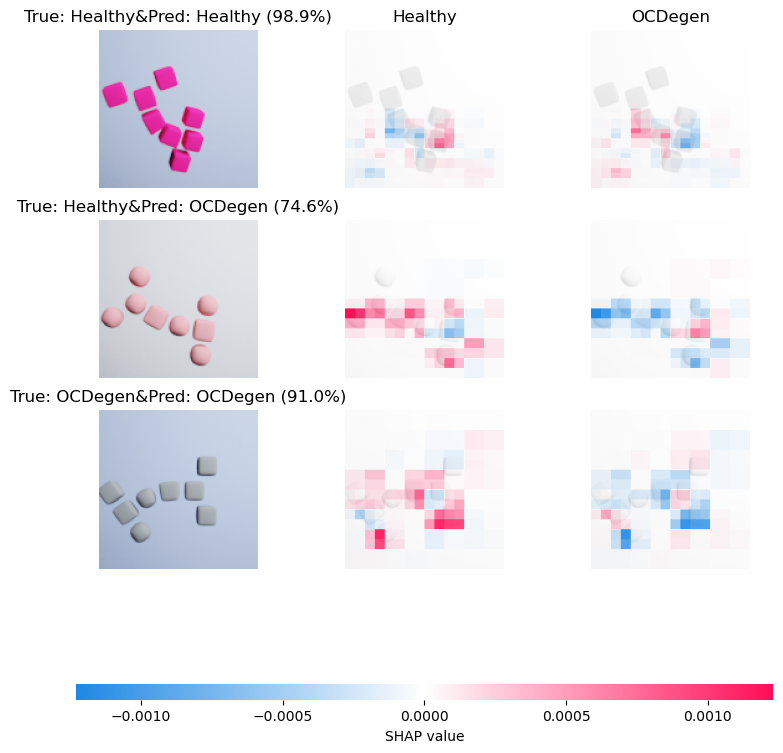

In [30]:
## Display SHAP exp
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=np.repeat([MainCLASSES], len(true_labels), axis=0), true_labels=list(labels),
)

2. GradientExplainer

In [44]:
background_data = torch.cat([test_dataset[i][0].unsqueeze(0) for i in range(50)], dim=0).to(device) 

In [45]:
explainer2 = shap.GradientExplainer(model, background_data)
shap_values2 = explainer2.shap_values(test_images)

In [46]:
# Convert images back to numpy for visualization
test_images_np = test_images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert from (N, C, H, W) to (N, H, W, C)
test_images_np = (test_images_np * np.array(std) + np.array(mean))  # Denormalize

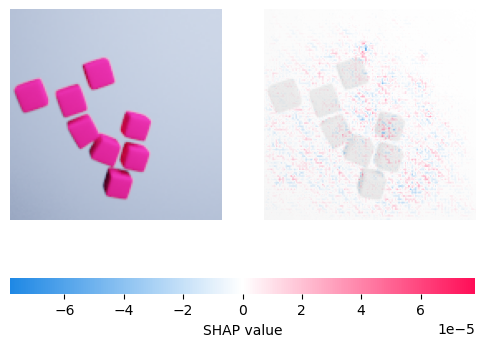

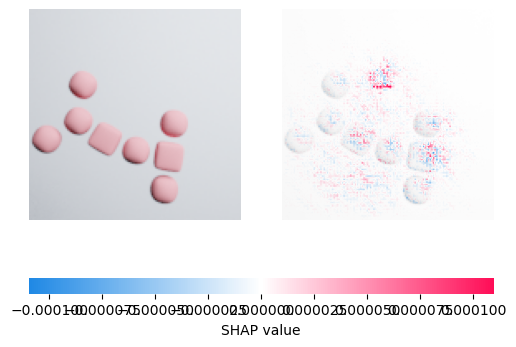

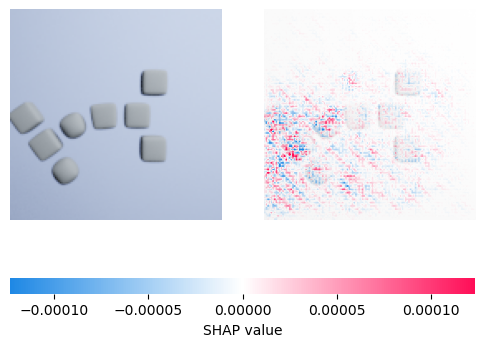

In [47]:
# Plot SHAP explanations without empty axes
for i in range(len(num_samples)):
    # SHAP Explanation
    shap.image_plot([shap_values2[i]], test_images_np[i:i+1])